# Install and Imports

In [1]:
# %pip install autoray
# %pip install opt_einsum

# !pip install --no-deps -U git+https://github.com/jcmgray/quimb.git@08ab4805df6be023e1027503b8c0915e1bf50b34
# %pip install -U git+https://github.com/jcmgray/cotengra.git
# !pip install kahypar
# %pip install nevergrad

In [3]:
# just set up some misc notebook plotting stuff

%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

In [4]:
import sys; sys.path.append('..')
import matplotlib.pyplot as plt
import quimb.tensor as qtn
import cotengra as ctg
import quimb as qu
import numpy as np
import time, random

# Main

### Utils

In [5]:

import pyzx as zx
import importlib
importlib.reload(zx)
zx.settings.drawing_backend = 'd3'
def show(g):
  return zx.draw_matplotlib(g,labels=True,h_edge_draw='box')
def show_d3(g):
  return zx.draw_d3(g)

In [6]:
def compute_stats(g):
    g1 = g.copy()
    from pyzx.hsimplify import to_hypergraph_form
    to_hypergraph_form(g1)
    count_hbox = 0
    count_z = 0
    count = 0
    one_arity = 0
    two_arity = 0
    three_arity = 0
    phase_hbox =0
    degree=0
    hbox_degree=0
    for v in g1.vertices():
        count_hbox+= g1.type(v)==3
        degree += len(g1.neighbors(v))
        hbox_degree += len(g1.neighbors(v)) if g1.type(v)==3 else 0
        if g1.type(v)==3:
            phase_hbox += ((len(g1.neighbors(v))!=1) and (g1.phase(v) != 1))
            one_arity+= len(g1.neighbors(v))==1
            two_arity+= len(g1.neighbors(v))==2
            three_arity+= len(g1.neighbors(v))==3
        count_z+=g1.type(v)==1
        count+=1
    print(f'H_box/Total = {count_hbox/count}')
    print(f'Z/Total = {count_z/count}')
    print(f'Multiarity Hbox/Total = {(two_arity+three_arity)/count}')
    print(f'Multiarity phase Hbox/Total = {phase_hbox/count_hbox}')
    print(f'total num of Z = {count_z}')
    print(f'total num of Hbox = {count_hbox}')
    print(f'One arity Hboxes = {one_arity}')
    print(f'Two arity Hboxes = {two_arity}')
    print(f'Three arity Hboxes = {three_arity}')
    print(f'Average degree = {degree/count}')
    print(f'Average Hbox degree = {hbox_degree/count}')

In [7]:
ctg.list_hyper_functions()

['betweenness',
 'flowcutter',
 'greedy',
 'greedy-compressed',
 'greedy-span',
 'kahypar',
 'kahypar-agglom',
 'kahypar-balanced',
 'labelprop',
 'labels',
 'labels-agglom',
 'quickbb',
 'spinglass',
 'walktrap']

In [8]:
def compute_contraction_costs(tn, progbar=True):
    print(f'#Tensors={tn.num_tensors}, #Indices={tn.num_indices}')
    print("-"*10+"-> Applying quimb's full_simplify ...")
    tn.full_simplify_('ADCRSL',output_inds=())
    print(f'#Tensors={tn.num_tensors}, #Indices={tn.num_indices}')
    opt = ctg.HyperOptimizer(
        methods=['greedy',
                'kahypar'],
        max_repeats=128,
        progbar=progbar,
        minimize='flops',
        score_compression=0.5,  # deliberately make the optimizer try many methods 
    )
    print("-"*10+"-> Finding contraction tree...")
    info = tn.contract(all, optimize=opt,output_inds=(), get='path-info')
    tree = opt.get_tree()
    print(f' Contraction cost = {tree.contraction_cost():e} \n Memory cost = {tree.contraction_width():e}')

### Quimb Tensor Contraction

In [9]:
file = 'circuits/depth_5.qsim'

In [10]:
circ2 = qtn.Circuit.from_qasm_file(file, gate_opts={})
psi_f = qtn.MPS_computational_state('0' * (circ2.N))
tn2 = circ2.psi  & psi_f
output_inds = []

In [28]:
compute_contraction_costs(tn2, progbar=True)

#Tensors=1764, #Indices=1978
-----------> Applying quimb's full_simplify ...
#Tensors=161, #Indices=313
-----------> Finding contraction tree...


log2[SIZE]: 28.00 log10[FLOPs]: 10.76: 100%|██████████| 128/128 [00:48<00:00,  2.62it/s]

 Contraction cost = 2.876780e+10 
 Memory cost = 2.800000e+01


### PyZX Tensor Contraction

In [11]:
circ1 = zx.Circuit.from_qsim_file(file)
g1 = circ1.to_graph(zh=True)
qubits = circ2.N
g1.apply_effect("0"*qubits)
g1.apply_state("0"*qubits)

In [12]:
from pyzx.hsimplify import to_gh
to_gh(g1)

In [34]:
show_d3(g1)

In [19]:
def hbox_arity(g):
    g1 = g.copy()
    from pyzx.hsimplify import to_hypergraph_form
    to_hypergraph_form(g1)
    count_hbox = 0
    count_z = 0
    count = 0
    one_arity = 0
    two_arity = 0
    three_arity = 0
    phase_hbox =0
    degree=0
    hbox_degree=0
    for v in g1.vertices():
        count_hbox+= g1.type(v)==3
        degree += len(g1.neighbors(v))
        hbox_degree += len(g1.neighbors(v)) if g1.type(v)==3 else 0
        if g1.type(v)==3:
            phase_hbox += ((len(g1.neighbors(v))!=1) and (g1.phase(v) != 1))
            one_arity+= len(g1.neighbors(v))==1
            two_arity+= len(g1.neighbors(v))==2
            three_arity+= len(g1.neighbors(v))==3
        count_z+=g1.type(v)==1
        count+=1
    # print(f'H_box/Total = {count_hbox/count}')
    # print(f'Z/Total = {count_z/count}')
    # print(f'Multiarity Hbox/Total = {(two_arity+three_arity)/count}')
    # print(f'Multiarity phase Hbox/Total = {phase_hbox/count_hbox}')
    # print(f'total num of Z = {count_z}')
    # print(f'total num of Hbox = {count_hbox}')
    # print(f'One arity Hboxes = {one_arity}')
    # print(f'Two arity Hboxes = {two_arity}')
    # print(f'Three arity Hboxes = {three_arity}')
    # print(f'Average degree = {degree/count}')
    # print(f'Average Hbox degree = {hbox_degree/count}')
    return 

In [ ]:

# simulated annealing
def anneal(g, iters=1000,
           temp=25,
           cool=0.005,
           score=g_wgc,
           cong_ps=[0.5, 0.5],
           lc_select=uniform_weights,
           pivot_select=uniform_weights,
           full_reduce_prob=0.1,
           reset_prob=0.0,
           quiet=False
):
    """Simulated annealing over a ZX-diagram generated by the congruences defined in
    congruences.py to minimize the supplied energy function"""

    g_best = g.copy()
    sz = score(g_best)
    sz_best = sz

    best_scores = list()

    for i in tqdm(range(iters), desc="annealing...", disable=quiet):

        g1 = g.copy()

        # cong_method = np.random.choice(["LC", "PIVOT"], 1, p=cong_ps)[0]
        cong_method = "PIVOT"

        if cong_method == "PIVOT":
            apply_rand_pivot(g1, weight_func=pivot_select)
        else:
            apply_rand_lc(g1, weight_func=lc_select)

        # probabilistically full_reduce:
        if random.uniform(0, 1) < full_reduce_prob:
            full_reduce(g1)
        sz1 = score(g1)

        best_scores.append(sz_best)
        
        if temp != 0: temp *= 1.0 - cool

        if sz1 < sz or \
            (temp != 0 and random.random() < math.exp((sz - sz1)/temp)):

            sz = sz1
            g = g1.copy()
            if sz < sz_best:
                g_best = g.copy()
                sz_best = sz
        elif random.uniform(0, 1) < reset_prob:
            g = g_best.copy()

    return g_best, best_scores


In [20]:
g_new,score = zx.local_search.simulated_annealing.anneal(g1,iters=100,score=hbox_arity, quiet=False)

annealing...: 100%|██████████| 100/100 [00:18<00:00,  5.40it/s]


In [21]:
score

[-0.9360878661087866,
 -0.9363370269705206,
 -0.9364747675269042,
 -1.1992590632442446,
 -1.1992590632442446,
 -1.1992590632442446,
 -1.1992590632442446,
 -1.1996834608282776,
 -1.1996834608282776,
 -1.205067920585162,
 -1.2058363731109953,
 -1.211314905709119,
 -1.2115037400051587,
 -1.2129082026227822,
 -1.2134975622273543,
 -1.2134975622273543,
 -1.2134975622273543,
 -1.2134975622273543,
 -1.2170266836086403,
 -1.2170266836086403,
 -1.2170266836086403,
 -1.2170266836086403,
 -1.2170266836086403,
 -1.2170266836086403,
 -1.2170266836086403,
 -1.2170266836086403,
 -1.2170266836086403,
 -1.2170266836086403,
 -1.2170266836086403,
 -1.2170266836086403,
 -1.2170266836086403,
 -1.2170266836086403,
 -1.2170266836086403,
 -1.2170266836086403,
 -1.2170266836086403,
 -1.2170266836086403,
 -1.2170266836086403,
 -1.2170266836086403,
 -1.2170266836086403,
 -1.2170266836086403,
 -1.2170266836086403,
 -1.2170266836086403,
 -1.2170266836086403,
 -1.2170266836086403,
 -1.2170266836086403,
 -1.21702668

In [15]:
hbox_arity(g_new)

-2.409866176856468

In [66]:
g = g1.copy()
zx.simplify.full_reduce(g,quiet=False)

spider_simp: 613. 372. 215. 12.  4 iterations
id_simp: 227.  1 iterations
spider_simp: 116. 109. 2.  3 iterations
lcomp_simp: 821. 93. 8.  3 iterations
id_simp: 1.  1 iterations
spider_simp: 1.  1 iterations
pivot_gadget_simp: 278. 134. 43. 1.  4 iterations
id_simp: 68.  1 iterations
spider_simp: 63. 5.  2 iterations
gadget_simp: 179.  1 iterations


In [72]:
hbox_arity(g)

2.401055408970976

In [70]:
score

[2.125732217573222,
 2.125732217573222,
 2.125732217573222,
 2.125732217573222,
 2.125732217573222,
 2.125732217573222,
 2.125732217573222,
 2.125732217573222,
 2.125732217573222,
 2.125732217573222,
 2.125732217573222,
 2.125732217573222,
 2.125732217573222,
 2.125732217573222,
 2.125732217573222,
 2.125732217573222,
 2.125732217573222,
 2.125732217573222,
 2.125732217573222,
 2.125732217573222,
 2.125732217573222,
 2.125732217573222,
 2.125732217573222,
 2.125732217573222,
 2.125732217573222,
 2.125732217573222,
 2.125732217573222,
 2.125732217573222,
 2.125732217573222,
 2.125732217573222,
 2.125732217573222,
 2.125732217573222,
 2.125732217573222,
 2.125732217573222,
 2.125732217573222,
 2.125732217573222,
 2.125732217573222,
 2.125732217573222,
 2.125732217573222,
 2.125732217573222,
 2.125732217573222,
 2.125732217573222,
 2.125732217573222,
 2.125732217573222,
 2.125732217573222,
 2.125732217573222,
 2.125732217573222,
 2.125732217573222,
 2.125732217573222,
 2.125732217573222,


In [36]:
show_d3(g_new)

In [50]:
compute_stats(g_new)

H_box/Total = 0.5808577405857741
Z/Total = 0.41914225941422595
Multiarity Hbox/Total = 0.35523012552301253
Multiarity phase Hbox/Total = 0.0
total num of Z = 4007
total num of Hbox = 5553
One arity Hboxes = 2157
Two arity Hboxes = 3396
Three arity Hboxes = 0
Average degree = 2.125732217573222


In [39]:
score

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [24]:
compute_stats(g1)

H_box/Total = 0.5827713726343268
Z/Total = 0.4172286273656733
Multiarity Hbox/Total = 0.3583859038503372
Multiarity phase Hbox/Total = 0.0
total num of Z = 7672
total num of Hbox = 10716
One arity Hboxes = 4126
Two arity Hboxes = 6590
Three arity Hboxes = 0
Average degree = 2.13454426800087


In [38]:
tn1 = zx.to_quimb_tensor(g_new)
compute_contraction_costs(tn1, progbar=True)

#Tensors=6765, #Indices=4007
-----------> Applying quimb's full_simplify ...
#Tensors=271, #Indices=277
-----------> Finding contraction tree...


log2[SIZE]: 12.00 log10[FLOPs]: 5.64: 100%|██████████| 128/128 [00:41<00:00,  3.11it/s]

 Contraction cost = 2.160000e+05 
 Memory cost = 1.200000e+01


In [25]:
tn1 = zx.to_quimb_tensor(g1)
compute_contraction_costs(tn1, progbar=True)

#Tensors=13035, #Indices=7672
-----------> Applying quimb's full_simplify ...
#Tensors=816, #Indices=825
-----------> Finding contraction tree...


log2[SIZE]: 26.00 log10[FLOPs]: 10.43: 100%|██████████| 128/128 [04:13<00:00,  1.98s/it]


 Contraction cost = 1.338125e+10 
 Memory cost = 2.600000e+01


In [13]:
zx.reduce_scalar(g1, quiet=False)

id_simp: 860.  1 iterations
spider_simp: 1068. 572. 215. 34.  4 iterations
id_simp: 14.  1 iterations
spider_simp: 14.  1 iterations


2

In [20]:
compute_stats(g1)

H_box/Total = 0.6525458248472505
Z/Total = 0.3474541751527495
Multiarity Hbox/Total = 0.3994568906992532
Multiarity phase Hbox/Total = 0.0
total num of Z = 2559
total num of Hbox = 4806
One arity Hboxes = 1864
Two arity Hboxes = 2942
Three arity Hboxes = 0
Average degree = 2.163204344874406


In [21]:
show_d3(g1)

In [22]:
tn1 = zx.to_quimb_tensor(g1)
compute_contraction_costs(tn1)

#Tensors=5024, #Indices=2559
-----------> Applying quimb's full_simplify ...
#Tensors=271, #Indices=277
-----------> Finding contraction tree...


log2[SIZE]: 13.00 log10[FLOPs]: 5.73: 100%|██████████| 128/128 [00:14<00:00,  8.54it/s]

 Contraction cost = 2.677280e+05 
 Memory cost = 1.300000e+01


In [14]:
from pyzx.hsimplify import zh_simp, new_simp
new_simp(g1)

spider_simp: 215. 215.  2 iterations
copy_simp: 48.  1 iterations
spider_simp: 48.  1 iterations
copy_simp: 1.  1 iterations
spider_simp: 1.  1 iterations
pivot_gadget_simp: 578. 291.  2 iterations
id_simp: 159.  1 iterations
spider_simp: 159.  1 iterations
hpivot: 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

10

In [18]:
compute_stats(g1)

H_box/Total = 0.7224919093851133
Z/Total = 0.27750809061488674
Multiarity Hbox/Total = 0.4716828478964401
Multiarity phase Hbox/Total = 0.24860022396416573
total num of Z = 1029
total num of Hbox = 2679
One arity Hboxes = 907
Two arity Hboxes = 1567
Three arity Hboxes = 182
Average degree = 2.523732470334412


In [24]:
compute_stats(g1)

H_box/Total = 0.7155887230514096
Z/Total = 0.28441127694859036
Multiarity Hbox/Total = 0.46185737976782754
Multiarity phase Hbox/Total = 0.22325222093472383
total num of Z = 1029
total num of Hbox = 2589
One arity Hboxes = 895
Two arity Hboxes = 1533
Three arity Hboxes = 138
Average degree = 2.469320066334992


In [25]:
show_d3(g1)

In [15]:
tn1 = zx.to_quimb_tensor(g1)
compute_contraction_costs(tn1)

#Tensors=5421, #Indices=2049
-----------> Applying quimb's full_simplify ...
#Tensors=482, #Indices=452


In [26]:
tn1 = zx.to_quimb_tensor(g1)
compute_contraction_costs(tn1)

#Tensors=2589, #Indices=1029
-----------> Applying quimb's full_simplify ...
#Tensors=227, #Indices=187
-----------> Finding contraction tree...


log2[SIZE]: 12.00 log10[FLOPs]: 5.65: 100%|██████████| 128/128 [00:27<00:00,  4.58it/s]

 Contraction cost = 2.243920e+05 
 Memory cost = 1.200000e+01


In [27]:
zx.full_reduce(g1, quiet=False)

lcomp_simp: 385. 85.  2 iterations


In [28]:
new_simp(g1,quiet=False)

par_hbox_simp: 141.  1 iterations


1

In [29]:
tn1 = zx.to_quimb_tensor(g1)
compute_contraction_costs(tn1)

#Tensors=1641, #Indices=559
-----------> Applying quimb's full_simplify ...
#Tensors=241, #Indices=174
-----------> Finding contraction tree...


log2[SIZE]: 12.00 log10[FLOPs]: 5.71: 100%|██████████| 128/128 [00:22<00:00,  5.73it/s]


 Contraction cost = 2.544480e+05 
 Memory cost = 1.200000e+01


In [ ]:
tn=tn1
info = tn.contract(all, optimize=opt_rg,output_inds=(), get='path-info')
f'{info.opt_cost/2:e}'

'5.26804e+5'

In [ ]:
tn1.contraction_cost( optimize=opt_rg,output_inds=())

Decimal('526804')

In [ ]:
tree = opt_rg.get_tree()
print(f' Contraction cost = {tree.contraction_cost():e} \n Memory cost = {tree.contraction_width():e}')

AttributeError: 'RandomGreedy' object has no attribute 'get_tree'

In [ ]:
# contraction cost
# N.B.  raw .opt_cost assumes *real* dtype FLOPs
#       * 4  to get complex dtype FLOPs (relevant for most QC)
#       / 2  to get dtype independent scalar OPs (the 'cost')
C = qu.log10(info.opt_cost / 2)
C

5.803022603874396

In [ ]:
tn1 = zx.to_quimb_tensor(g1)
tn1.contraction_cost(output_inds=())   

Decimal('6630461')

In [ ]:
303/6765, 186/4000

1_000_000


1000000

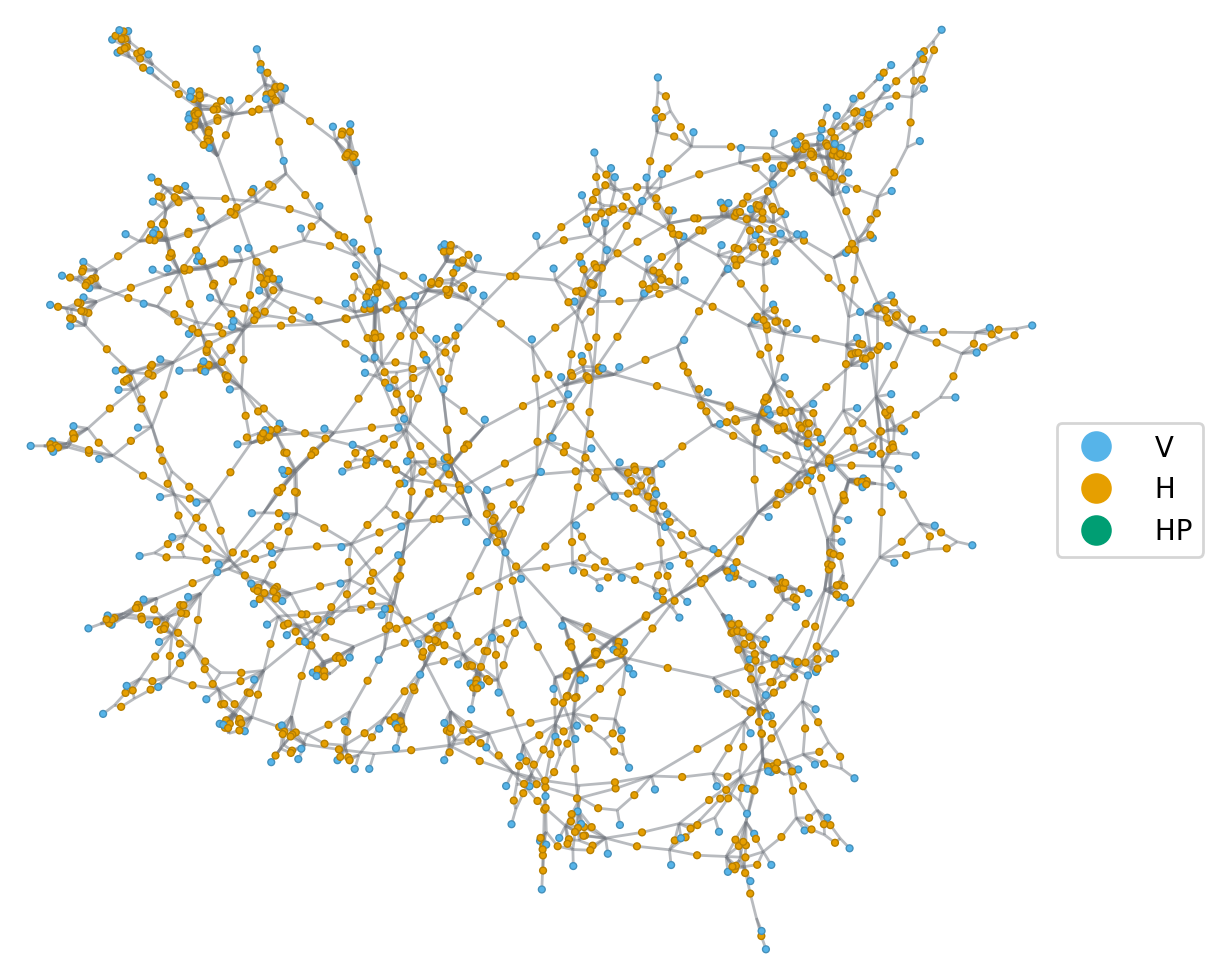

In [ ]:
tn1 = zx.to_quimb_tensor(g1)
tn1.draw(color=['V','H','HP'])